#  Capstone Two - Pre-processing and Training Data Development


### Since I previously created dummy features for all categorical variables in the last step of my Capstone Two project (see Capstone Two_EDA.ipynb), and the original dataset includes both the training and testing sets, I will skip these steps. Instead, this notebook will focus on standardizing the magnitude of numeric features using a scaler.

<style>
h4 { margin-bottom: 5px; }  /* Reduces space after headings */
p { margin-top: 2px; margin-bottom: 3px; }  /* Reduces space between paragraphs */
</style>

### Scaling Numeric Features Efficiently
Scaling as many as 138 numeric features efficiently requires a systematic approach to ensure consistency across both the training and testing datasets. I will proceed with the whole scaling procedure in five steps:
#### 1. Identify Numeric Features
Extract all numeric features from the dataset.
#### 2. Analyze Distribution of Non-binary Numeric Features
Examine the distribution of each feature to determine the most suitable scaling method.
#### 3. Classify Variables into Different Scalers
Classify features into one of the following scaling methods:  
&nbsp;&nbsp;&nbsp;&nbsp;**StandardScaler**: For normally distributed features.  
&nbsp;&nbsp;&nbsp;&nbsp;**MinMaxScaler**: For features with a fixed range (e.g., [0,1]).  
&nbsp;&nbsp;&nbsp;&nbsp;**RobustScaler**: For features with outliers.  
&nbsp;&nbsp;&nbsp;&nbsp;**PowerTransformer**: For skewed distributions.  
#### 4. Apply Different Scaling Methods to Each Non-Binary Numerical Variable
Use the selected scaler for each category of features.
#### 5. Save the Transformed Dataset
Store the transformed dataset for model training.


# 1. Identify Numeric Features
Since I have already converted all categorical variables to numeric, all remaining features should be numeric. However, confirm this by checking the data types.

In [253]:
import pandas as pd
import numpy as np

# Load datasets 
df_train = pd.read_csv('df_train_EDA.csv')
df_test = pd.read_csv('df_test_EDA.csv')

# Identify numeric features
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Total numeric features in training dataset: {len(numeric_features)}')
print(f'\nTotal categorical features in training dataset: {len(categorical_features)}')
print(f'\nTotal features in training dataset: {len(df_train.columns.tolist())}')


Total numeric features in training dataset: 151

Total categorical features in training dataset: 0

Total features in training dataset: 151


It has been confirmed that all features are numeric. Typically, one-hot encoded features do not require scaling, so I can focus my efforts on scaling the remaining features instead.

In [254]:
binary_features = []
feature2scale = []

for feature in df_train.columns.tolist():
    if df_train[feature].nunique() == 2:
        binary_features.append(feature)
    
    elif feature != 'Id':
        feature2scale.append(feature)

print(f'Total number of features requiring scaling is: {len(feature2scale)}')
print(f'Total number of binary features is: {len(binary_features)}')

Total number of features requiring scaling is: 39
Total number of binary features is: 111


In [255]:
for feature in binary_features:
    unique_values = set(df_train[feature].unique())
    if unique_values != {0, 1}:
        print(f'{feature} in training dataset: {unique_values}')

KitchenAbvGr in training dataset: {1, 2}


In [256]:
for feature in binary_features:
    unique_values = set(df_test[feature].unique())
    if unique_values != {0, 1}:
        print(f'{feature} in testing dataset: {unique_values}')

KitchenAbvGr in testing dataset: {1, 2}


Since I have 111 binary variables in {0,1} format, normalizing KitchenAbvGr to a [0,1] range makes the most sense.

In [257]:
df_train['KitchenAbvGr'] = df_train['KitchenAbvGr'] - 1
df_test['KitchenAbvGr'] = df_test['KitchenAbvGr'] - 1

# 2. Analyze Distribution of Non-binary Numeric Features

Not all numeric features require the same scaling technique. The choice of scaler depends on the distribution of the data:

- **StandardScaler (Z-score normalization)** → Best for normally distributed data. 
- **MinMaxScaler (Rescales between 0 and 1)** → Best for features with a fixed range. 
- **RobustScaler (Uses median and IQR)** → Best for data with outliers.  
- **PowerTransformer (Box-Cox or Yeo-Johnson)** → Helps with skewed data.

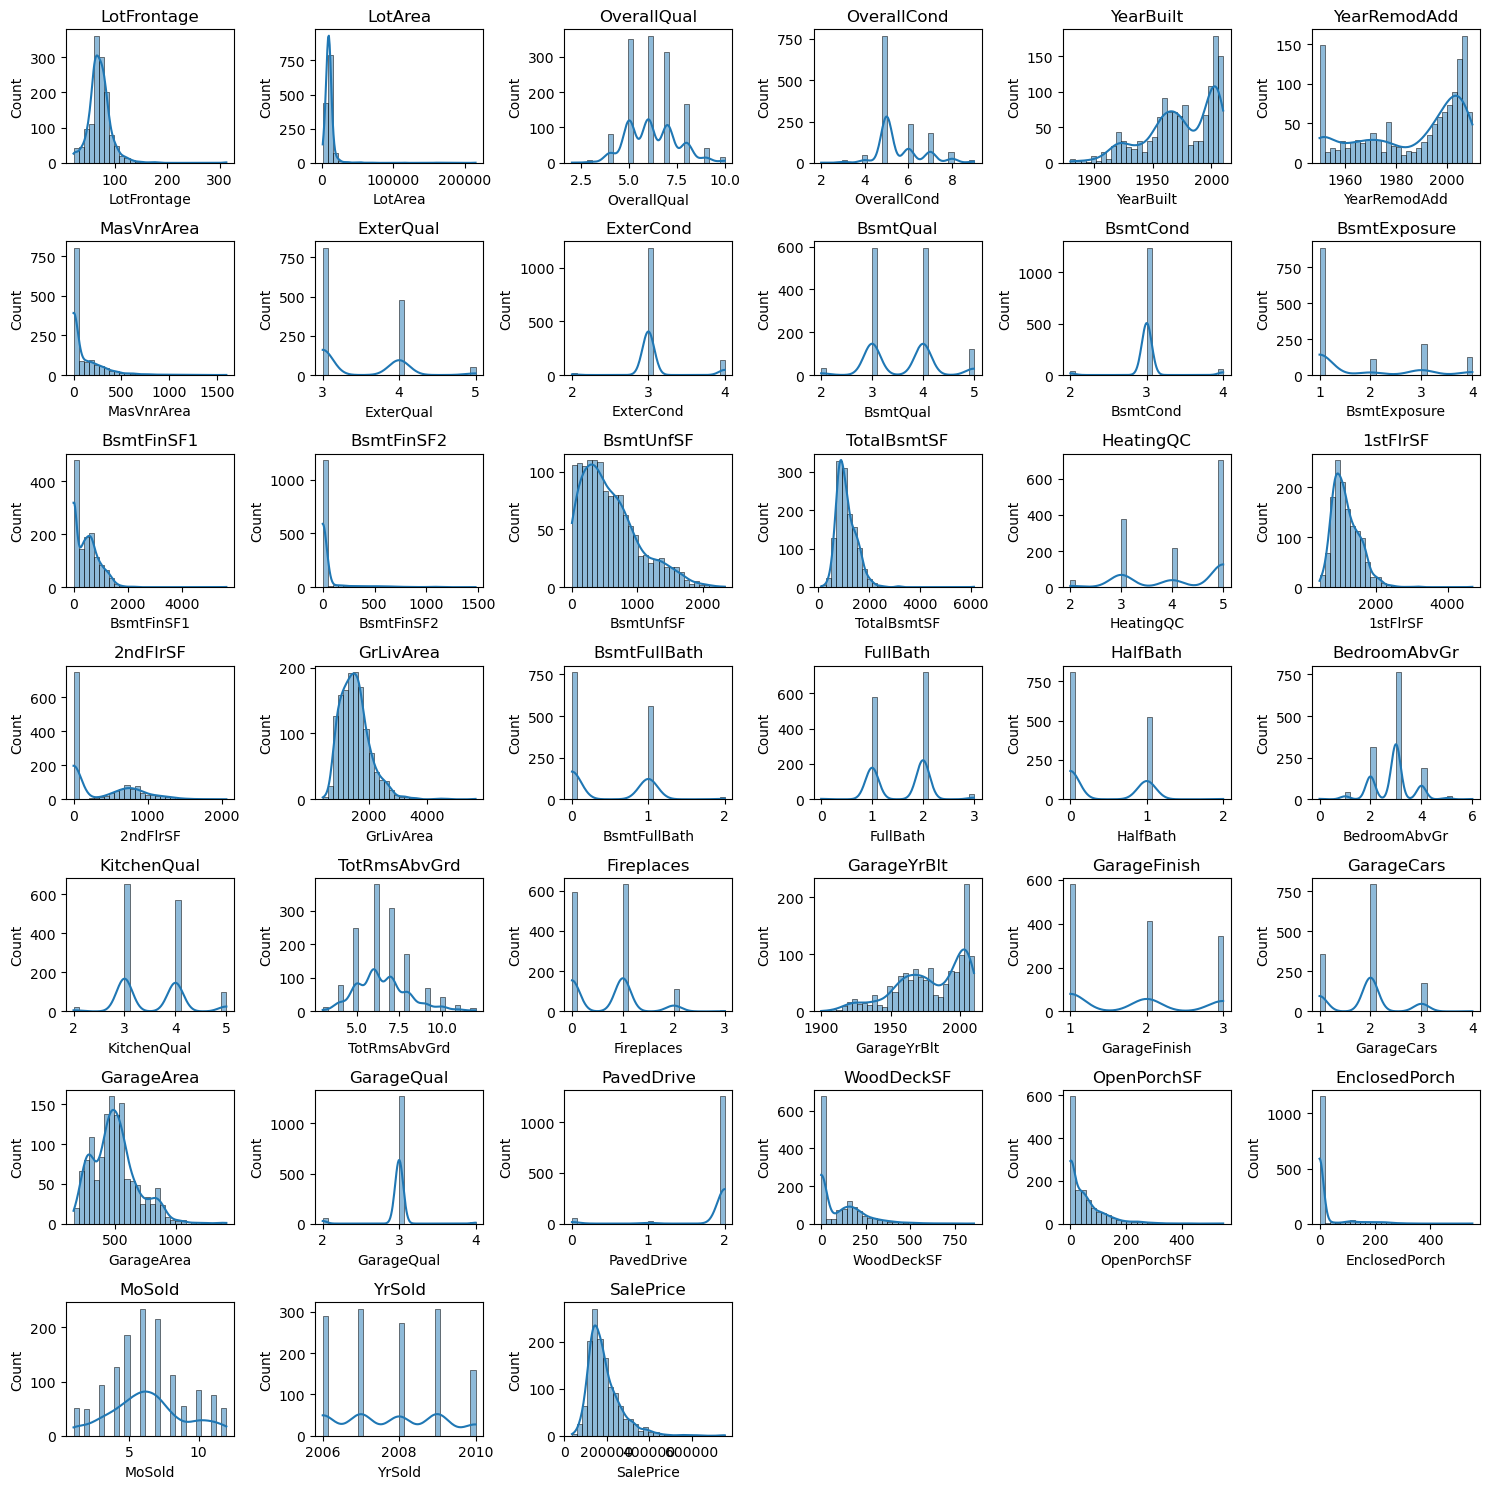

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns 

# Plot distributions
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(feature2scale):
    sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots (if any)
for idx in range(i + 1, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# 3. Classify Variables into Different Scalers

### Scaler Selection Logic

|Condition | Best Scaling Method |
|------------| -------------------- |
|Year variables (YearBuilt, YrSold, YearRemodAdd)| Subtract Reference Year |
|Month variable (MoSold) | Sin-Cos Transformation |
|Ordinal variable| MinMaxScaler | 
|Near-normal distributions with limited outliers| StandardScaler | 
|Non-Gaussian but no extreme outliers | MinMaxScaler | 
|Strong outliers, large spread, or moderate skew | RobustScaler | 
|Highly skewed (e.g., >1.0), heavy-tailed distribution | Log Transformation | 

## 3.1 Automatic assignment

Aside from the year variables (YearBuilt, YrSold, YearRemodAdd), which will be adjusted by subtracting a reference year, and the month variable (MoSold), which will be transformed using the Sin-Cos transformation, all remaining variables will be automatically assigned to different scalers using the customized function auto_assign_scalers().

In [259]:
# Function to automatically classify variables into scalers based on statistical thresholds and predefined ordinal variables
def auto_assign_scalers(feat2scale, ordinal_vars=None):
    """
    Automatically assigns numerical variables to appropriate scalers based on statistical thresholds.
    
    Parameters:
        feat2scale: A list of numerical variables needed to be scaled.
        ordinal_vars (list): List of ordinal variables that should use MinMaxScaler.
        
    Returns:
        dict: Dictionary containing scaler assignments for each variable.
    """
    if ordinal_vars is None:
        ordinal_vars = []  # Default empty list if no ordinal variables specified
    
    scaler_groups = {"MinMaxScaler": [], "StandardScaler": [], "RobustScaler": [], "LogTransform": []}
    statistics = {'Scaler': [], 'Variable': [], 'Why': [], 'Outlier_count': [], 'Skewness': [] , 'Kurtosis': [], 'Range_val/IQR':[]}

    for col in feat2scale:
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)][col]

        # Compute relevant statistics
        range_val = df_train[col].max() - df_train[col].min()
        median_distance = df_train[col].max() - df_train[col].median()
        outlier_count = len(outliers)
        skewness = df_train[col].skew()
        kurtosis = df_train[col].kurt()

        # Special handling for ordinal variables (force MinMaxScaler)
        if col in ordinal_vars:
            # For discrete ordinal variables, assign highly skewed ones for RobustScaler
            if outlier_count > 10:  
                scaler_groups["RobustScaler"].append(col)
                statistics['Scaler'].append("RobustScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('ordinal variable with outlier > 10')
            # For discrete ordinal variables, remaining for MinMaxScaler
            else:
                scaler_groups["MinMaxScaler"].append(col)
                statistics['Scaler'].append("MinMaxScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('ordinal variables')
        else:
            # For remaining continuous variables, firstly, find out normal distribution and assign them under Standard scaler
            # StandardScaler only for near-normal distributions with limited outliers
            if outlier_count < 5 and abs(skewness) < 0.5 and abs(kurtosis) < 3.0 and range_val < 5 * IQR:
                scaler_groups["StandardScaler"].append(col)
                statistics['Scaler'].append("StandardScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('outlier < 5 & skew < 0.5 & kurtosis < 3 & range < 5 * IQR')
            # For remaining continuous variables, secondly, find out less normal distribution and assign them under MinMaxScaler
            # MinMaxScaler for non-Gaussian but no extreme outliers
            elif outlier_count < 5 and abs(skewness) < 0.5 and range_val < 10 * IQR:
                scaler_groups["MinMaxScaler"].append(col)
                statistics['Scaler'].append("MinMaxScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('outlier < 5 & skew < 0.5 & range < 10 * IQR')
            # For remaining continuous variables, thirdly, find out extreme skewed distribution and assign them under Log Transformation. As the degree of skewness increases, PowerTransformer generally performs better than RobustScaler.
            # Log Transform for highly skewed distributions with heavy tails
            elif abs(skewness) > 1.0 and kurtosis > 2.0:
                scaler_groups["LogTransform"].append(col)
                statistics['Scaler'].append("LogTransform")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR if IQR != 0 else np.nan)
                statistics['Why'].append('skew > 1.0 & kurtosis > 2.0') 
            # For remaining continuous variables, fourthly, find out less extreme skewed distribution and assign them under RobustScaler
            # RobustScaler for strong outliers, large spread, or moderate skew
            elif outlier_count > 5 or range_val > 10 * IQR or abs(skewness) > 0.5:
                scaler_groups["RobustScaler"].append(col)
                statistics['Scaler'].append("RobustScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('outlier > 5 or skew > 0.5  or range > 10 * IQR')
            # For remaining continuous variables, at last, assign the remaining variables for MinMaxScaler
            else:
                scaler_groups["MinMaxScaler"].append(col)  # Default to StandardScaler
                statistics['Scaler'].append("MinMaxScaler")
                statistics['Variable'].append(col)
                statistics['Outlier_count'].append(outlier_count)
                statistics['Skewness'].append(abs(skewness))
                statistics['Kurtosis'].append(abs(kurtosis))
                statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
                statistics['Why'].append('Default as MinMaxScaler')  

    return scaler_groups,  statistics

# Define ordinal and categorical variables
ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'GarageFinish', 'GarageQual', 'PavedDrive', 'GarageCars', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Firepalces', 'TotRmsAbvGrd']  # Provide a list of ordinal variables 

undet_vars = list(set(feature2scale) - set(['YearBuilt', 'YrSold', 'YearRemodAdd', 'MoSold']))

# Apply the improved function to classify 39 numerical variables
scaler_results_final, statistics = auto_assign_scalers(undet_vars, ordinal_vars=ordinal_variables)

# Display the assigned scalers for each variable
scaler_df_final = pd.DataFrame({key: pd.Series(val) for key, val in scaler_results_final.items()})
statistics_df = pd.DataFrame({key: pd.Series(val) for key, val in statistics.items()})

scaler_df_final

,MinMaxScaler,StandardScaler,RobustScaler,LogTransform
0,BsmtFullBath,NaN,2ndFlrSF,WoodDeckSF
1,BsmtExposure,NaN,OverallCond,LotFrontage
2,HeatingQC,NaN,GarageYrBlt,LotArea
3,GarageFinish,NaN,PavedDrive,1stFlrSF
4,OverallQual,NaN,BsmtCond,EnclosedPorch
5,KitchenQual,NaN,ExterCond,GrLivArea
6,FullBath,NaN,TotRmsAbvGrd,TotalBsmtSF
7,GarageCars,NaN,BsmtUnfSF,SalePrice
8,BsmtQual,NaN,GarageArea,BsmtFinSF2
9,HalfBath,NaN,BedroomAbvGr,OpenPorchSF


In [260]:
statistics_df.sort_values(by='Scaler', inplace=True)

# tools.display_dataframe_to_user(name="Final Automatic Scaler Assignment for 39 Variables", dataframe=scaler_df_final)
statistics_df.to_excel('Non-binary numeric variable statisitcs.xlsx')
statistics_df

,Scaler,Variable,Why,Outlier_count,Skewness,Kurtosis,Range_val/IQR
34,LogTransform,BsmtFinSF1,skew > 1.0 & kurtosis > 2.0,6,1.693397,11.630118,7.699864
21,LogTransform,TotalBsmtSF,skew > 1.0 & kurtosis > 2.0,20,2.214029,18.372875,11.908775
22,LogTransform,SalePrice,skew > 1.0 & kurtosis > 2.0,56,1.943686,6.815307,8.466929
11,LogTransform,GrLivArea,skew > 1.0 & kurtosis > 2.0,29,1.430307,5.324558,8.240697
27,LogTransform,BsmtFinSF2,skew > 1.0 & kurtosis > 2.0,162,4.146519,18.985684,NaN
29,LogTransform,OpenPorchSF,skew > 1.0 & kurtosis > 2.0,65,2.250952,7.628230,7.814286
7,LogTransform,1stFlrSF,skew > 1.0 & kurtosis > 2.0,17,1.397431,6.058740,8.180769
8,LogTransform,EnclosedPorch,skew > 1.0 & kurtosis > 2.0,183,3.205286,11.314761,NaN
5,LogTransform,LotArea,skew > 1.0 & kurtosis > 2.0,76,11.938124,191.844258,53.263210
3,LogTransform,LotFrontage,skew > 1.0 & kurtosis > 2.0,84,2.331226,20.668154,14.600000


## 3.2 Distribution of Features Classified Under StandardScaler

These features should appear to have distributions that are approximately normal (bell-shaped, symmetric, and centered around a mean with no heavy skew or extreme outliers). However, none of the variables have a clear normal distribution. Most features are either skewed, have discrete values, or exhibit heavy tails/outliers, so StandardScaler isn’t the best fit here.

In [261]:
# # Plot distributions
# nrows = int(np.ceil(len(scaler_df_final['StandardScaler'].dropna())/3))
# fig, axes = plt.subplots(nrows, ncols=5, figsize=(15, 2 * nrows))
# axes = axes.flatten()

# for i, col in enumerate(scaler_df_final['StandardScaler'].dropna()):
#     try:
#         sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i])
#         axes[i].set_title(col)
#     except KeyError:
#         print(col)

# # Remove empty subplots (if any)
# for idx in range(i + 1, len(axes)):
#     fig.delaxes(axes[idx])

# print(len(scaler_df_final['StandardScaler'].dropna()))

# plt.tight_layout()
# plt.show()

## 3.3 Distribution of Features Classified Under MinMaxScaler

These features have a clear, __finite range__ or a distribution that could benefit from rescaling to a [0, 1] range __without needing to handle skewness or outliers extensively__. This is often suitable for __discrete__ , __ordinal__ or __bounded__ numeric features.

11


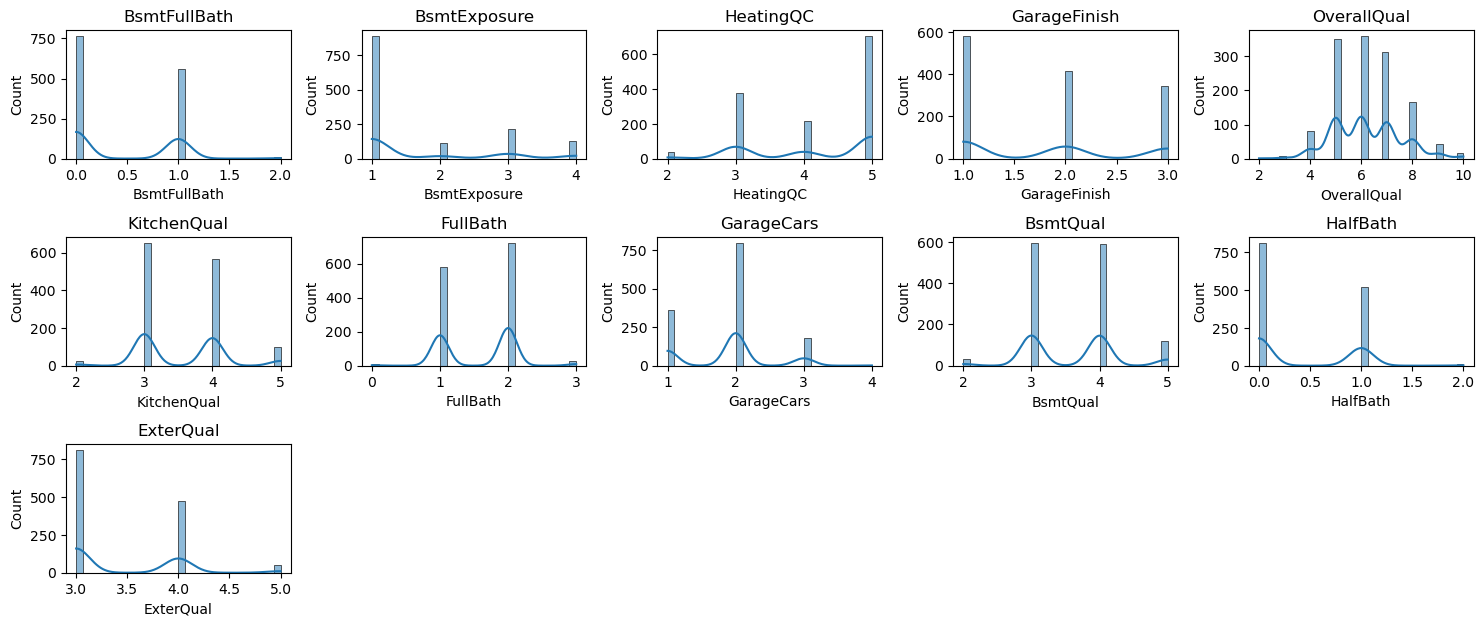

In [262]:
# Plot distributions
nrows = int(np.ceil(len(scaler_df_final['MinMaxScaler'].dropna())/3))
fig, axes = plt.subplots(nrows, ncols=5, figsize=(15, 2 * nrows))
axes = axes.flatten()

for i, col in enumerate(scaler_df_final['MinMaxScaler'].dropna()):
    try:
        sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(col)
    except KeyError:
        print(col)

# Remove empty subplots (if any)
for idx in range(i + 1, len(axes)):
    fig.delaxes(axes[idx])

print(len(scaler_df_final['MinMaxScaler'].dropna()))

plt.tight_layout()
#plt.show()

## 3.4 Distribution of Features Classified Under RobustScaler

These features show distributions with potential outliers or heavy tails, where the median and interquartile range (IQR) are better measures for scaling than mean and standard deviation.

12


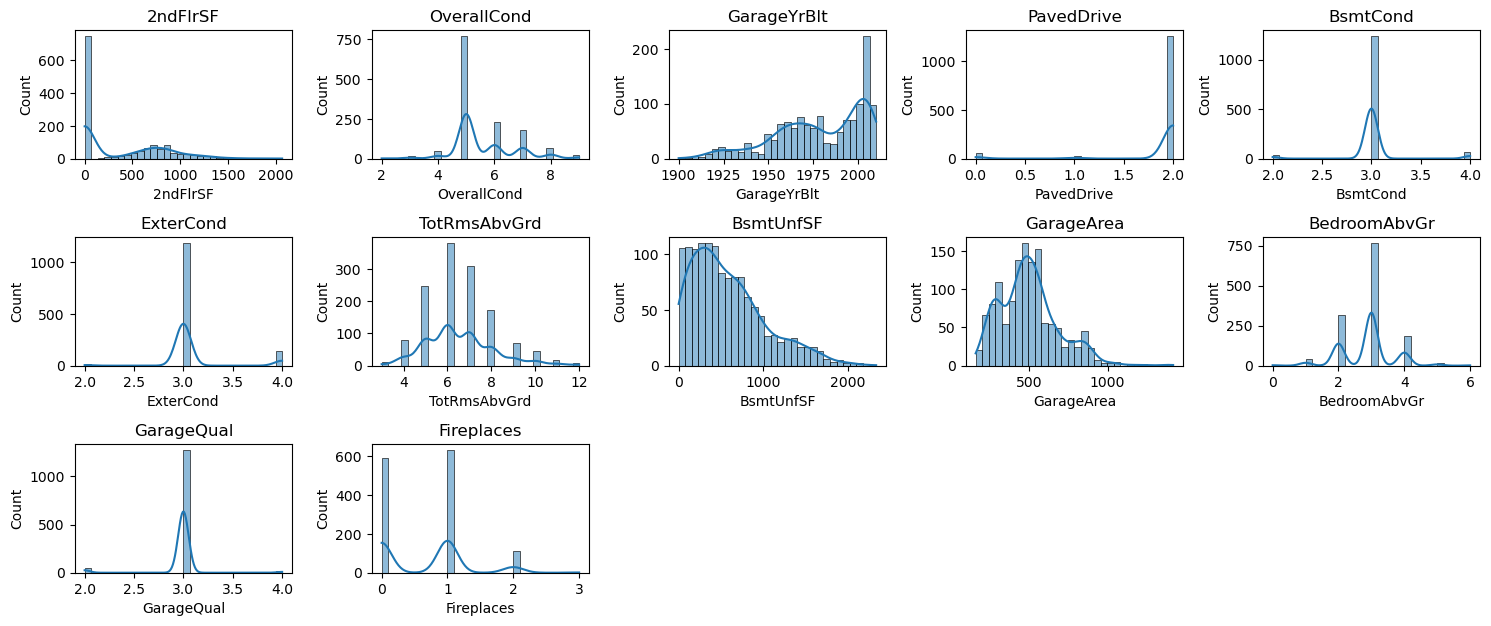

In [263]:
# Plot distributions
nrows = int(np.ceil(len(scaler_df_final['RobustScaler'].dropna())/3))
fig, axes = plt.subplots(nrows, ncols=5, figsize=(15, 2 * nrows))
axes = axes.flatten()

for i, col in enumerate(scaler_df_final['RobustScaler'].dropna()):
    try:
        sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(col)
    except KeyError:
        print(col)

# Remove empty subplots (if any)
for idx in range(i + 1, len(axes)):
    fig.delaxes(axes[idx])

print(len(scaler_df_final['RobustScaler'].dropna()))

plt.tight_layout()
#plt.show()

## 3.5 Distribution of Features Classified Under Log Transformation

As the degree of skewness increases, Log Transformation generally performs better than RobustScaler. Log Transformation will normalize them closer to a Gaussian distribution. 

12


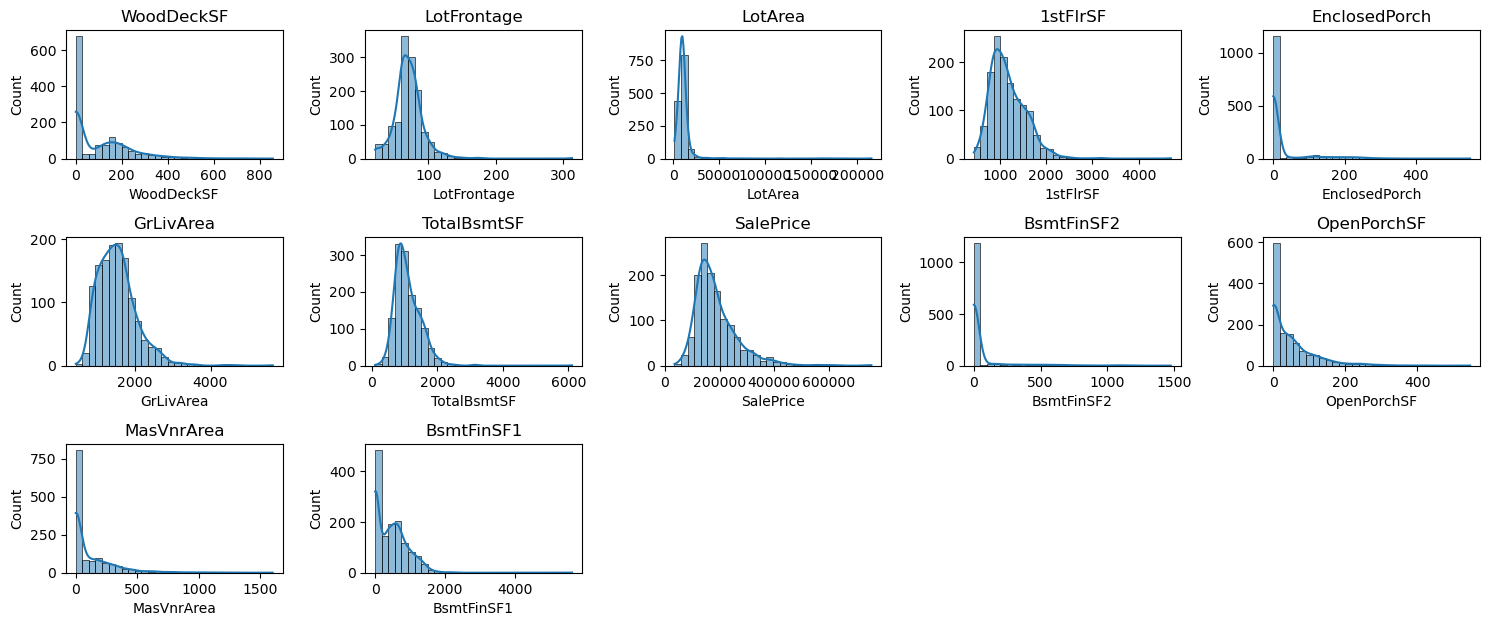

In [264]:
# Plot distributions
nrows = int(np.ceil(len(scaler_df_final['LogTransform'].dropna())/3))
fig, axes = plt.subplots(nrows, ncols=5, figsize=(15, 2 * nrows))
axes = axes.flatten()

for i, col in enumerate(scaler_df_final['LogTransform'].dropna()):
    try:
        sns.histplot(df_train[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(col)
    except ValueError:
        print('Number of rows must be a positive integer, not 0')

# Remove empty subplots (if any)
for idx in range(i + 1, len(axes)):
    fig.delaxes(axes[idx])

print(len(scaler_df_final['LogTransform'].dropna()))

plt.tight_layout()
#plt.show()

## 3.6 Scaler assignment in final

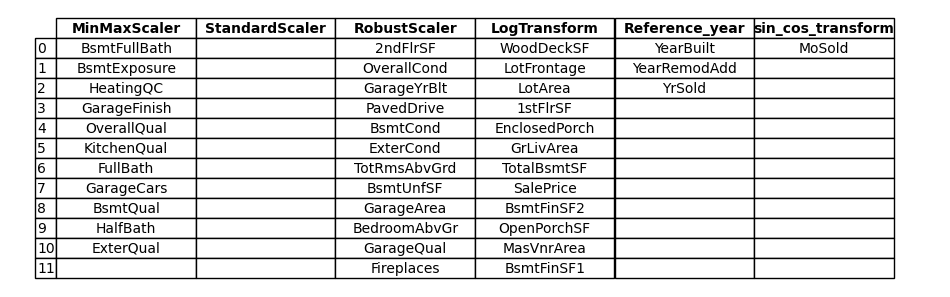

In [265]:
scaler_df_final['Reference_year'] = ['YearBuilt', 'YearRemodAdd', 'YrSold'] + [None] * (len(scaler_df_final) - 3)
scaler_df_final['sin_cos_transform'] = ['MoSold']+ [None] * (len(scaler_df_final) - 1)
scaler_df_final = scaler_df_final.fillna('')

# Set up figure and axis
fig, ax = plt.subplots(figsize=(12, len(scaler_df_final) * 0.3))  # Adjust height based on number of rows

# Hide axes
ax.axis('off')

# Create the table and add it to the plot
table = pd.plotting.table(ax, scaler_df_final, loc='center', cellLoc='center', colWidths=[0.15]*len(scaler_df_final.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

# Bold the header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

# Save as image
# image_path = "/mnt/data/scaler_assignment.png"
plt.savefig("figures/scaler_assignment.jpg", bbox_inches='tight', dpi=300, pad_inches=0)


# 4. Apply Different Scaling Methods to Each Numerical Variable Requiring Scaling.

In [266]:
# Before scaling OverallQual
print("Scaler data_min_:", df_train['OverallQual'].min())
print("Scaler data_max_:", df_train['OverallQual'].max())

Scaler data_min_: 2
Scaler data_max_: 10


In [267]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
import pickle

# Define the methods dictionary
method_dict = {
    'reference_year': lambda df, col, ref_year: df[col] - ref_year,
    'sin_cos_transform': lambda df, col: (
        df.assign(**{f"{col}_sin": np.sin(2 * np.pi * df[col] / 12),
                     f"{col}_cos": np.cos(2 * np.pi * df[col] / 12)}).drop(columns=[col])
    ),
    'MinMaxScaler': lambda: MinMaxScaler(), # Factory function to create a new instance
    'StandardScaler': lambda: StandardScaler(),
    'RobustScaler': lambda: RobustScaler(),
    'LogTransform': lambda df, col: np.log1p(df[col])  # log(1 + X) to handle zero values
}

# Define a dictionary of each variable as key and its assigned scaler as value
variable_to_method = dict(zip(statistics['Variable'], statistics['Scaler']))
variable_to_method.update({
    'YearBuilt': 'reference_year',
    'YearRemodAdd': 'reference_year',
    'YrSold': 'reference_year',
    'MoSold': 'sin_cos_transform'
})

# Debug: Check the range of OverallQual before any transformations
print("Before any transformations:")
print("df_train['OverallQual'].min():", df_train['OverallQual'].min())
print("df_train['OverallQual'].max():", df_train['OverallQual'].max())

# Create a dictionary to store fitted scalers
scaler_instances = {}

# Apply scaler methods
for col in feature2scale:
    # Debug: Check the range of OverallQual before any transformations
    print(f"\nProcessing column: {col}")
    print("Before processing:")
    print("df_train['OverallQual'].min():", df_train['OverallQual'].min())
    print("df_train['OverallQual'].max():", df_train['OverallQual'].max())

    method = variable_to_method[col]
    # Create a new scaler instance for each column
    scaler = method_dict[method]() if method in ['MinMaxScaler', 'StandardScaler', 'RobustScaler'] else method_dict[method]

    if col in ['YearBuilt', 'YearRemodAdd', 'YrSold']:
        # Subtract reference year
        ref_year = df_train[col].min()
        df_train[col] = scaler(df_train, col, ref_year)
        df_test[col] = scaler(df_test, col, ref_year)
        print(f'reference year for {col} is {ref_year}')
        
    elif col == 'MoSold':
        # Apply sin-cos transformation and update DataFrames
        df_train = scaler(df_train, col)
        df_test = scaler(df_test, col)

    elif method == 'LogTransform':
        # Apply log transformation
        df_train[col] = scaler(df_train, col)
        if col in df_test.columns:
            df_test[col] = scaler(df_test, col)

    else:
        # Debug: Check the data being passed to the scaler
        if col == 'OverallQual':
            print("Data being passed to scaler.fit() for OverallQual:")
            print("df_train[['OverallQual']].min():", df_train[['OverallQual']].min())
            print("df_train[['OverallQual']].max():", df_train[['OverallQual']].max())

        # Fit on train, transform on both train and test
        scaler_instances[col] = scaler.fit(df_train[[col]])
        df_train[col] = scaler_instances[col].transform(df_train[[col]])
        df_test[col] = scaler_instances[col].transform(df_test[[col]])
    
    print(f"df_train['OverallQual'].min() after processing {col}:", df_train['OverallQual'].min())
    print(f"df_train['OverallQual'].max() after processing {col}:", df_train['OverallQual'].max())

# After scaling, check the fitted range of the scaler
print("\nAfter scaling, check the fitted range of the scaler:")
print("Scaler data_min_:", scaler_instances['OverallQual'].data_min_)
print("Scaler data_max_:", scaler_instances['OverallQual'].data_max_)
print("Scaler feature_range:", scaler_instances['OverallQual'].feature_range)

# Display first few rows of transformed datasets
# print("Transformed Training Dataset:")
# print(df_train.head())

# print("\nTransformed Testing Dataset:")
# print(df_test.head())

#  Save Transformed Data to CSV 
# df_train.to_csv("transformed_train.csv", index=False)
# df_test.to_csv("transformed_test.csv", index=False)
print("Transformed datasets saved as CSV files.")

# Save the fitted scalers
with open('fitted_scalers.pkl', 'wb') as f:
    pickle.dump(scaler_instances, f)

Before any transformations:
df_train['OverallQual'].min(): 2
df_train['OverallQual'].max(): 10

Processing column: LotFrontage
Before processing:
df_train['OverallQual'].min(): 2
df_train['OverallQual'].max(): 10
df_train['OverallQual'].min() after processing LotFrontage: 2
df_train['OverallQual'].max() after processing LotFrontage: 10

Processing column: LotArea
Before processing:
df_train['OverallQual'].min(): 2
df_train['OverallQual'].max(): 10
df_train['OverallQual'].min() after processing LotArea: 2
df_train['OverallQual'].max() after processing LotArea: 10

Processing column: OverallQual
Before processing:
df_train['OverallQual'].min(): 2
df_train['OverallQual'].max(): 10
Data being passed to scaler.fit() for OverallQual:
df_train[['OverallQual']].min(): OverallQual    2
dtype: int64
df_train[['OverallQual']].max(): OverallQual    10
dtype: int64
df_train['OverallQual'].min() after processing OverallQual: 0.0
df_train['OverallQual'].max() after processing OverallQual: 1.0

Proces

In [268]:
# After scaling, check the fitted range of the scaler
print("Scaler data_min_:", scaler_instances['OverallQual'].data_min_)
print("Scaler data_max_:", scaler_instances['OverallQual'].data_max_)
print("Scaler feature_range:", scaler_instances['OverallQual'].feature_range)

Scaler data_min_: [2.]
Scaler data_max_: [10.]
Scaler feature_range: (0, 1)


In [269]:
df_test.shape

(1459, 151)

# 5. Visualize Relationships Between Variables

### 5.1 Correlation Matrix and Heatmap View

In [270]:
# To display only the rows and columns that contain yellow background cells and exclude those without
corr_matrix = df_train.corr()
threshold = 0.5
# Identify the cells that meet the threshold condition
highlight_mask = (abs(corr_matrix) > threshold) & (abs(corr_matrix) < 1)
# Filter rows and columns with at least one highlighted cell
rows_to_keep = highlight_mask.any(axis=1)
cols_to_keep = highlight_mask.any(axis=0)      

# Extract the relevant portion of the correlation matrix
filtered_corr_matrix = corr_matrix.loc[rows_to_keep, cols_to_keep]

# Style the filtered correlation matrix
styled_filtered_corr_matrix = filtered_corr_matrix.style.applymap(
    lambda x: 'background-color: yellow' if abs(x) > threshold and abs(x) < 1 else ''
    )
# Disply the styled matrix
styled_filtered_corr_matrix

C:\Users\Sheng Miao\AppData\Local\Temp\ipykernel_50008\89106773.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_filtered_corr_matrix = filtered_corr_matrix.style.applymap(


,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,GarageYrBlt,GarageFinish,GarageCars,GarageArea,SalePrice,MSSubClass_60,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_190,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Mod+,Neighborhood_OldTown,Condition1_Feedr,Condition1_Norm,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Others,HouseStyle_SFoyer,HouseStyle_SLvl,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_CBlock,Foundation_PConc,BsmtFinType1_Unf,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Functional_Min2,Functional_Others,Functional_Typ,GarageType_Detchd,GarageCond_Others,GarageCond_TA,SaleType_New,SaleType_WD,SaleCondition_Partial
LotFrontage,1.000000,0.670444,0.203562,0.067978,0.051126,0.143278,0.133948,0.076949,0.057015,0.142953,0.392856,0.083727,0.486347,0.015276,0.339625,0.099092,0.171053,-0.010409,0.275893,0.025388,0.150713,0.338888,0.036983,0.194120,0.276950,0.338462,0.371930,0.187063,0.036159,0.071732,0.014183,0.049255,-0.246467,-0.545158,0.013119,0.417997,-0.382117,0.042363,0.077044,-0.077328,0.077515,-0.088184,0.054378,-0.074656,0.010680,0.049255,-0.491359,-0.383676,0.125595,-0.081217,-0.025719,-0.047243,0.045814,0.038017,-0.063344,-0.015080,-0.140240,0.034649,0.019911,0.074834,0.051774,-0.012748,0.003598,-0.078319,-0.010575,-0.142223,0.109348,0.006697,0.086264,0.042494,-0.061650,0.042588,0.022341,-0.044776,0.015992,0.055471,-0.053423,0.013697,-0.043549,0.022301,-0.287397,-0.006528,0.038054,0.111616,-0.082292,0.110133
LotArea,0.670444,1.000000,0.155609,-0.010751,0.007315,0.082195,0.092138,0.087776,0.089927,0.062631,0.365344,0.038903,0.455295,0.075299,0.370513,0.145079,0.157271,0.027229,0.281817,0.010404,0.103852,0.357017,-0.020875,0.149528,0.244800,0.307357,0.389400,0.204666,0.040651,0.055935,0.000327,0.018039,-0.304283,-0.545913,0.079123,0.454189,-0.387463,0.075035,0.271053,-0.209754,0.227330,-0.085705,0.038643,-0.094036,0.072467,0.018039,-0.455044,-0.439442,0.055546,-0.054163,-0.004519,-0.060495,0.032830,0.065973,-0.078883,-0.013718,-0.141449,0.099809,0.011640,0.013003,0.088763,-0.009812,0.056006,-0.102778,0.000990,-0.144738,0.169313,0.008775,0.027085,0.060538,-0.049382,0.052932,-0.030701,-0.042035,0.022407,0.074638,-0.085708,0.033790,0.005984,-0.029330,-0.233022,-0.004485,0.021256,0.056838,-0.034678,0.060426
OverallQual,0.203562,0.155609,1.000000,0.570668,0.549460,0.722328,0.672961,-0.023086,-0.138284,0.292940,0.467117,0.449863,0.456300,0.281145,0.611175,0.083254,0.580425,0.249283,0.081994,-0.136139,0.667729,0.442941,0.545835,0.516528,0.591878,0.530092,0.807486,0.340009,0.038411,-0.037804,-0.077172,-0.107081,0.165967,-0.006505,-0.116332,0.132927,-0.209730,0.107611,-0.022284,-0.005671,-0.052296,-0.165234,-0.122171,0.101334,-0.123554,-0.107081,0.005608,0.116978,-0.088486,0.265854,0.000270,-0.097579,-0.047778,-0.005280,0.135497,-0.118277,-0.199335,-0.062195,0.029002,0.355899,-0.161347,-0.025096,0.009614,0.149746,-0.094450,-0.191630,-0.113450,-0.013263,0.359366,-0.164800,0.010968,-0.480077,0.566404,0.054407,-0.068494,-0.103166,0.142929,-0.128083,-0.023363,0.147677,-0.409873,-0.058580,0.159807,0.332307,-0.235661,0.327228
YearBuilt,0.067978,-0.010751,0.570668,1.000000,0.617156,0.592714,0.725856,0.112638,-0.095083,0.147762,0.390809,0.454093,0.255291,0.006989,0.222680,0.175108,0.486777,0.227626,-0.080644,-0.171556,0.519624,0.099415,0.825172,0.583219,0.524076,0.4438

In [271]:
filtered_corr_matrix.shape

(86, 86)

In [272]:
# To display only the rows and columns that contain yellow background cells and exclude those without
corr_matrix = df_train.corr()
threshold = 0.8
# Identify the cells that meet the threshold condition
highlight_mask = (abs(corr_matrix) > threshold) & (abs(corr_matrix) < 1)
# Filter rows and columns with at least one highlighted cell
rows_to_keep = highlight_mask.any(axis=1)
cols_to_keep = highlight_mask.any(axis=0)      

# Extract the relevant portion of the correlation matrix
filtered_corr_matrix = corr_matrix.loc[rows_to_keep, cols_to_keep]

# Style the filtered correlation matrix
styled_filtered_corr_matrix = filtered_corr_matrix.style.applymap(
    lambda x: 'background-color: red' if abs(x) > threshold and abs(x) < 1 else ''
    )
# Disply the styled matrix
styled_filtered_corr_matrix

C:\Users\Sheng Miao\AppData\Local\Temp\ipykernel_50008\2620582487.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_filtered_corr_matrix = filtered_corr_matrix.style.applymap(


,OverallQual,YearBuilt,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SalePrice,MSSubClass_80,MSSubClass_190,MSZoning_RL,MSZoning_RM,BldgType_2fmCon,HouseStyle_2Story,HouseStyle_SLvl,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,BsmtFinType1_Unf,BsmtFinType2_Unf,SaleType_New,SaleCondition_Partial
OverallQual,1.000000,0.570668,-0.023086,-0.138284,0.467117,0.456300,0.281145,0.611175,0.442941,0.545835,0.591878,0.530092,0.807486,-0.037804,-0.116332,0.132927,-0.209730,-0.123554,0.265854,-0.047778,0.135497,-0.118277,-0.199335,0.355899,-0.161347,0.149746,-0.094450,-0.191630,0.359366,-0.164800,-0.480077,0.566404,0.054407,0.142929,0.332307,0.327228
YearBuilt,0.570668,1.000000,0.112638,-0.095083,0.390809,0.255291,0.006989,0.222680,0.099415,0.825172,0.524076,0.443854,0.572592,0.004926,-0.175720,0.260974,-0.397518,-0.175729,0.189551,0.008074,0.093711,0.004500,-0.204977,0.539836,-0.420954,0.109825,-0.004407,-0.194757,0.537186,-0.401820,-0.314006,0.649886,-0.095599,0.095955,0.352432,0.348773
BsmtFinSF1,-0.023086,0.112638,1.000000,0.174482,0.227254,0.190993,-0.179915,-0.042645,-0.101489,0.012100,0.004346,0.065315,0.147954,0.051602,0.000893,0.201149,-0.183850,-0.007954,-0.138904,0.062185,0.064290,0.138584,-0.008205,-0.131465,-0.088363,0.049772,0.132373,-0.004433,-0.131925,-0.066598,0.253218,-0.113615,-0.966819,-0.182681,-0.127316,-0.127083
BsmtFinSF2,-0.138284,-0.095083,0.174482,1.000000,0.055050,0.066214,-0.113826,-0.060813,-0.054406,-0.115729,-0.105677,-0.059735,-0.066312,0.070624,-0.030413,0.106899,-0.065086,-0.031881,-0.105248,0.077463,-0.012350,0.073742,-0.034796,-0.154359,0.046930,-0.039496,0.079843,-0.032528,-0.163625,0.074422,0.262732,-0.214872,-0.236150,-0.988408,-0.113560,-0.108035
TotalBsmtSF,0.467117,0.390809,0.227254,0.055050,1.000000,0.844150,-0.253490,0.401159,0.272061,0.315742,0.444687,0.481727,0.592748,-0.110193,-0.057346,0.321796,-0.303484,-0.057646,-0.263605,-0.138293,0.099829,-0.081480,-0.155380,0.176546,-0.121441,0.095671,-0.056429,-0.146616,0.172537,-0.101674,-0.119988,0.253053,-0.184849,-0.042924,0.237912,0.238855
1stFlrSF,0.456300,0.255291,0.190993,0.066214,0.844150,1.000000,-0.241064,0.524072,0.385924,0.227384,0.441612,0.488097,0.607801,0.033716,-0.001857,0.345418,-0.286867,-0.005168,-0.331124,0.024172,0.104734,-0.093451,-0.164771,0.085406,-0.037694,0.089021,-0.059182,-0.161160,0.086207,-0.037239,-0.083943,0.170970,-0.148617,-0.055921,0.197088,0.197101
2ndFlrSF,0.281145,0.006989,-0.179915,-0.113826,-0.253490,-0.241064,1.000000,0.665928,0.619275,0.060414,0.187208,0.124564,0.308708,-0.083607,0.021298,-0.097743,0.040817,0.016048,0.816780,-0.089883,0.018404,-0.042102,-0.043234,0.102357,-0.006755,0.019587,-0.031046,-0.047727,0.102294,-0.019265,-0.250392,0.194411,0.184288,0.107958,0.010444,0.003958
GrLivArea,0.611175,0.222680,-0.042645,-0.060813,0.401159,0.524072,0.665928,1.000000,0.824129,0.247458,0.498127,0.466511,0.729048,-0.051837,0.011232,0.149769,-0.169522,0.002889,0.481560,-0.064384,0.097403,-0.117267,-0.156631,0.168380,-0.043622,0.087167,-0.075864,-0.158290,0.166802,-0.053021,-0.306384,0.327380,0.076491,0.065200,0.170824,0.164621
TotRmsAbvGrd,0.442941,0.099415,-0.101489,-0.054406,0.272061,0.385924,0.619275,0.824129,1.000000,0.148625,0.404416,0.368435,0.551437,-0.035862,0.043447,0.157783,-0.137622,0.033005,0.441131,-0.046868,0.083255,-0.075150,-0.142006,0.129134,-0.013266,0.086087,-0.044415,-0.141591,0.129836,-0.027651,-0.218965,0.206029,0.122679,0.055108,0.158031,0.151861
GarageYrBlt,0.545835,0.825172,0.012100,-0.115729,0.315742,0.227384,0.060414,0.247458,0.148625,1.000000,0.590301,0.563860,0.536262,-0.031232,-0.123475,0.143774,-0.272355,-0.121773,0.182104,-0.030994,0.097882,-0.046939,-0.197983,0.535792,-0.334039,0.107585,-0.049356,-0.196533,0.532035,-0.324930,-0.415520

In [273]:
filtered_corr_matrix.shape

(36, 36)

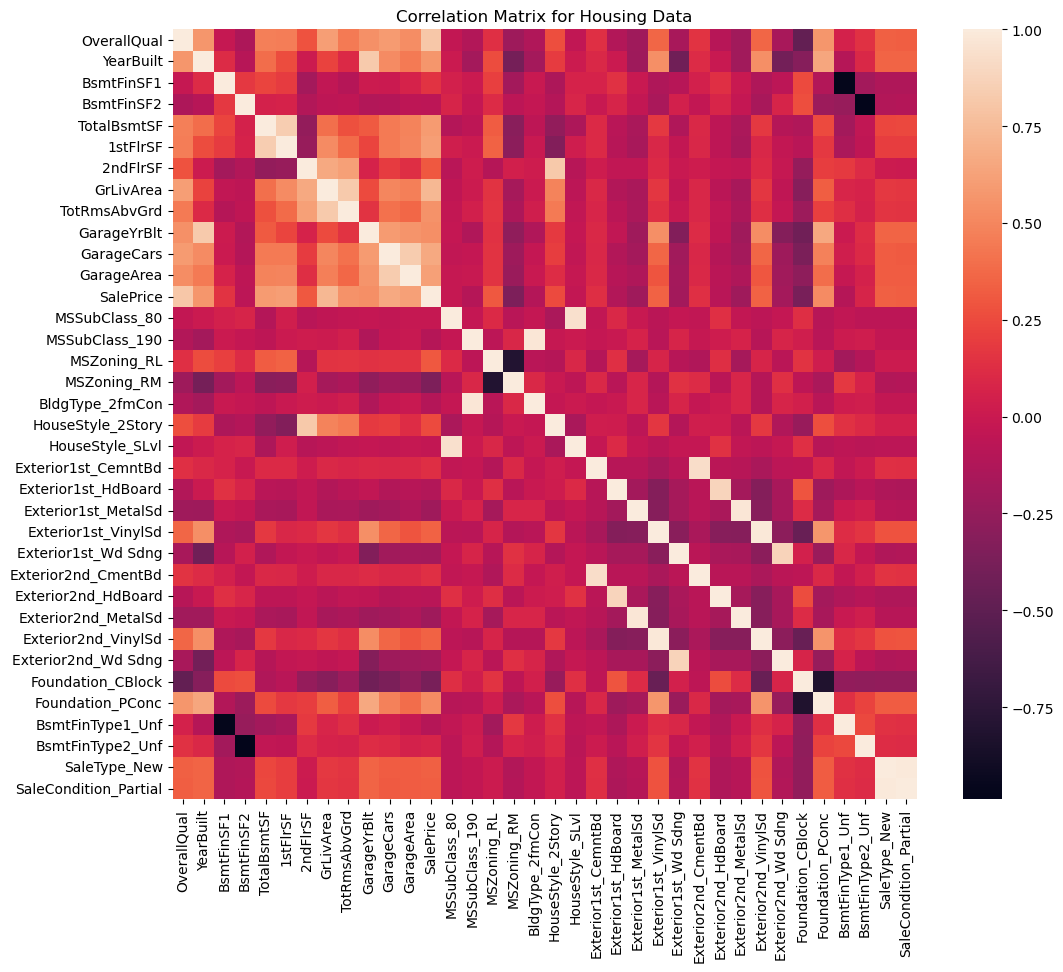

In [274]:
# Make a heatmap of the filtered maxtrix
plt.subplots(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix)
plt.title('Correlation Matrix for Housing Data')
# plt.savefig('Correlation Matrix for Housing Data.jpg')
plt.show()

In [275]:
# To display only the rows and columns that contain yellow background cells and exclude those without
corr_matrix = df_train.corr()

# Extract the relevant portion of the correlation matrix
corr_matrix_withPrice = corr_matrix.loc[['SalePrice'], (abs(corr_matrix['SalePrice']) > 0.5) & (abs(corr_matrix['SalePrice']) < 1) ]
price_corr_features = corr_matrix_withPrice.columns.tolist()

# Sort in descending order by absolute correlation values
corr_matrix_withPrice = corr_matrix_withPrice.T
corr_matrix_withPrice = corr_matrix_withPrice.abs().sort_values(by='SalePrice', ascending=False)

# Disply the matrix
corr_matrix_withPrice

,SalePrice
OverallQual,0.807486
GrLivArea,0.729048
ExterQual,0.668704
BsmtQual,0.664109
KitchenQual,0.662174
GarageCars,0.660141
GarageArea,0.612695
FullBath,0.612604
1stFlrSF,0.607801
TotalBsmtSF,0.592748


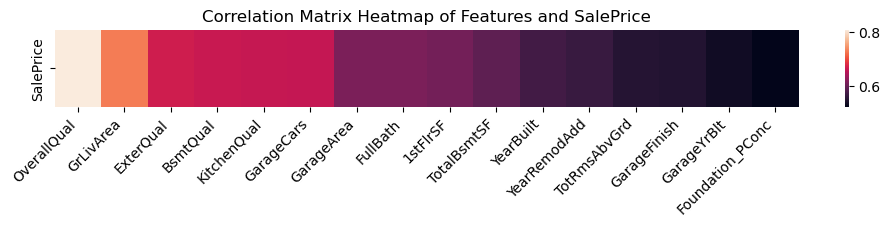

In [276]:
# Make Correlation Matrix Heatmap of Features and SalePrice
corr_matrix_withPrice = corr_matrix.loc[['SalePrice'], (abs(corr_matrix['SalePrice']) > 0.5) & (abs(corr_matrix['SalePrice']) < 1) ]
price_corr_features = corr_matrix_withPrice.columns.tolist()

# Sort in descending order by absolute correlation values
corr_matrix_withPrice = corr_matrix_withPrice.T
corr_matrix_withPrice = corr_matrix_withPrice.abs().sort_values(by='SalePrice', ascending=False)
corr_matrix_withPrice = corr_matrix_withPrice.T

plt.subplots(figsize=(12, 1))
sns.heatmap(corr_matrix_withPrice)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix Heatmap of Features and SalePrice')
# plt.savefig('Correlation Matrix Heatmap of Features and SalePrice.jpg')
plt.show()

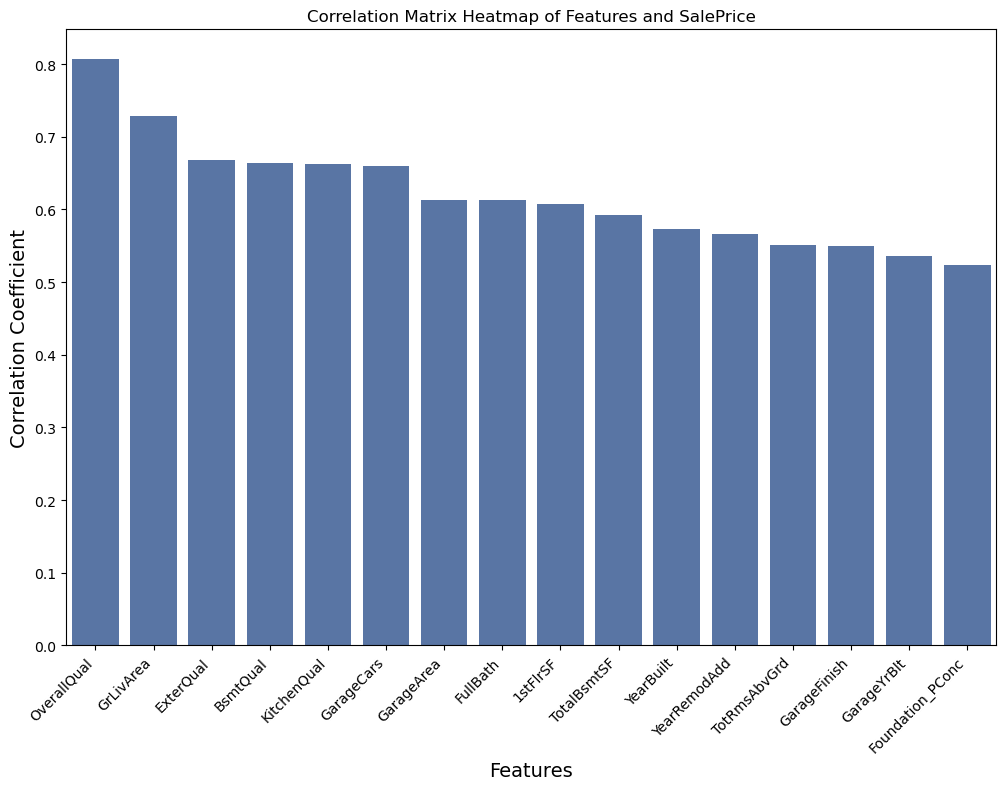

In [277]:
plt.subplots(figsize=(12, 8))
sns.barplot(corr_matrix_withPrice, color='#4C72B0')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix Heatmap of Features and SalePrice')
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xlabel('Features', fontsize=14)
# plt.savefig('Correlation Matrix Heatmap of Features and SalePrice.jpg')
plt.show()